In [1]:
import requests
from bs4 import BeautifulSoup
from gunningfog import GunningFog

# session = requests.Session()
# session.headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.1.2222.33 Safari/537.36",
#     "Accept-Encoding": "*",
#     "Connection": "keep-alive"
# }
# response = session.get(request_url)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# url = "https://seekingalpha.com/article/4236503-apple-inc-aapl-ceo-tim-cook-on-q1-2019-results-earnings-call-transcript"
# req = requests.get(url)
# # https://github.com/h5py/h5py/issues/1477

In [3]:
# soup = BeautifulSoup(req.content, "html.parser")

In [4]:
# text = soup.get_text().split("\n")

In [5]:
# execs = []
# for i in range(len(text)):
#     if text[i] == "Company Participants":
#         pos = i + 1
#         while text[pos] != "Conference Call Participants":
#             execs.append(text[pos].split("-")[0][:-1])
#             pos += 1
#         break

In [6]:
# start = text.index(execs[0]) + 1

# def make_lst(start, text):
#     exec_lst = []
#     for i in range(start, len(text)):
#         phrase = text[i].strip()
#         if phrase == "Question-and-Answer Session":
#             break
#         elif phrase in execs:
#             continue
#         else:
#             exec_lst.append(phrase)
#     return exec_lst

# exec_lst = make_lst(start, text)

In [7]:
# exec_str = ""
# for phrase in exec_lst:
#     exec_str += phrase + " "

In [8]:
# fog = GunningFog(exec_str)

In [9]:
# print(fog.gFogIndex())

In [10]:
# import pandas as pd

In [11]:
# df = pd.read_csv('data.csv')

In [12]:
# companies = list(df)

In [13]:
# companies = companies[1:]
# print(companies)

In [14]:
# def make_lst(start, text):
#             exec_lst = []
#             for i in range(start, len(text)):
#                 phrase = text[i].strip()
#                 if phrase == "Question-and-Answer Session":
#                     break
#                 elif phrase in execs:
#                     continue
#                 else:
#                     exec_lst.append(phrase)
#             return exec_lst
        
def gunning_fog_lst(comp_urls):
    complexities = []
    for url in comp_urls:
        req = requests.get(url)
        soup = BeautifulSoup(req.content, "html.parser")
        text = soup.get_text().split("\n")
        
        execs = []
        for i in range(len(text)):
            if text[i] == "Company Participants":
                pos = i + 1
                while text[pos] != "Conference Call Participants":
                    execs.append(text[pos].split("-")[0][:-1])
                    pos += 1
                break
                
        start = text.index(execs[0]) + 1
        exec_lst = []
        for i in range(start, len(text)):
            phrase = text[i].strip()
            if phrase == "Question-and-Answer Session":
                break
            elif phrase in execs:
                continue
            else:
                exec_lst.append(phrase)
                    
        exec_str = ""
        for phrase in exec_lst:
            exec_str += phrase + " "
            
        fog = GunningFog(exec_str)
        
        complexities.append(fog.gFogIndex())
    return complexities

In [15]:
# AIG, AIMC, ALL, ALLT, BCO, CADE, CLAR, DE, DXPE, HHC, HURN, INFU, INSM
# session = requests.Session()
# session.headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.1.2222.33 Safari/537.36",
#     "Accept-Encoding": "*",
#     "Connection": "keep-alive"
# }

comp_urls = ["https://seekingalpha.com/article/4261066-american-international-group-inc-aig-ceo-brian-duperreault-on-q1-2019-results-earnings-call",
             "https://seekingalpha.com/article/4257313-altra-industrial-motion-corp-aimc-ceo-carl-christenson-on-q1-2019-results-earnings-call",
             "https://seekingalpha.com/article/4259328-allstate-corporation-all-ceo-tom-wilson-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263877-allot-ltd-allt-ceo-on-erez-antebi-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4256277-brinks-company-bco-ceo-doug-pertz-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4257794-cadence-bancorporation-cade-ceo-paul-murphy-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4260743-clarus-corporation-clar-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4241565-deere-and-company-de-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263033-dxp-enterprises-inc-dxpe-ceo-david-little-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4261129-howard-hughes-corporations-hhc-ceo-david-weinreb-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4258852-huron-consulting-group-inc-hurn-ceo-james-roth-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4263856-infusystem-holdings-inc-infu-ceo-rich-dilorio-on-q1-2019-results-earnings-call-transcript",
             "https://seekingalpha.com/article/4260973-insmed-inc-insm-ceo-william-lewis-on-q1-2019-results-earnings-call-transcript",
#              "https://seekingalpha.com/article/4236503-apple-inc-aapl-ceo-tim-cook-on-q1-2019-results-earnings-call-transcript",
#              "https://seekingalpha.com/article/4256968-amazon-com-inc-amzn-q1-2019-results-earnings-call-transcript"
            ]

complexity_list = gunning_fog_lst(comp_urls)

print(complexity_list)

[15.436101225702547, 13.360783990051559, 14.085951219512197, 13.616715716313989, 14.459105668058095, 13.62897531771649, 15.602926057840225, 13.524035740501683, 11.710533018009825, 13.5795195954488, 13.613526804687027, 12.268684025334272, 14.20848192547592]


In [16]:
import pandas as pd
df = pd.read_csv('data.csv')
companies = list(df)
companies = companies[1:]
# print(companies)

newDf = df[["AIG", "AIMC", "ALL", "ALLT", "BCO", "CADE", "CLAR", "DE", "DXPE", "HHC", "HURN", "INFU", "INSM"]].copy()

l = []
for i in range(len(newDf.columns)):
    l.append(100*(newDf.iloc[12,i] - newDf.iloc[0,i])/newDf.iloc[0,i])

df2 = pd.DataFrame(l, index= ["AIG", "AIMC", "ALL", "ALLT", "BCO", "CADE", "CLAR", "DE", "DXPE", "HHC", "HURN", "INFU", "INSM"])

returns_list = list(df2[0])

print(returns_list)

[8.859197833637097, 20.236342189896856, 15.204743497891563, 31.22977155255791, 15.43822628741082, 6.834791265235797, 25.269341122244068, 5.027244301956937, 34.45790472915619, 8.1909290829718, -3.8477146309859864, 40.92218519214513, 36.765395047134916]


Figure(432x432)


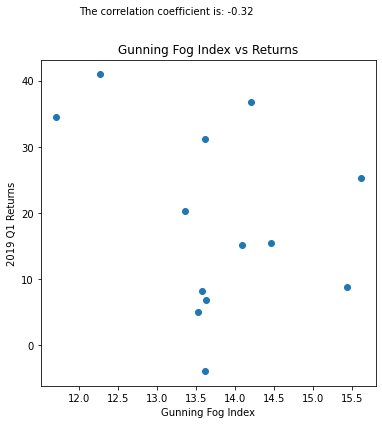

In [74]:
from matplotlib import pyplot as plt #import pyplot library
import numpy as np #import numpy library

#calculate the correlation coefficient
my_number = np.corrcoef(complexity_list, returns_list)[0,1]

#create a subplot
fig, ax = plt.subplots(figsize = (6, 6))

#add a scatter graph to the axis
ax.scatter(complexity_list, returns_list)

#set title
ax.title.set_text('Gunning Fog Index vs Returns')

#set axis labels
ax.set(xlabel = 'Gunning Fog Index', ylabel = '2019 Q1 Returns')

#add the correlation coefficient to the axis
ax.text(12, 50, "The correlation coefficient is: " + str(np.round(my_number, 2)))

#prints the figure
print(fig)

Figure(432x432)


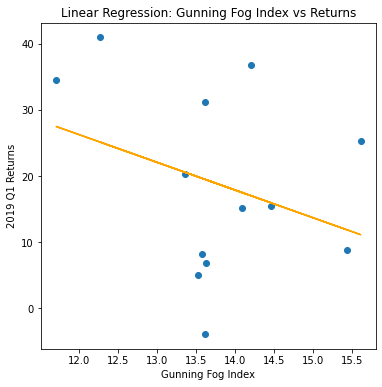

In [75]:
#create a subplot
fig2, ax2 = plt.subplots(figsize = (6, 6))

#turns the complexity_list into a numpy array
x = np.array(complexity_list)

#create basic scatterplot
ax2.scatter(complexity_list, returns_list)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(complexity_list, returns_list, 1)

#add linear regression line to scatterplot
ax2.plot(x, m*x+b, 'orange')

#sets a title
ax2.title.set_text('Linear Regression: Gunning Fog Index vs Returns')

#sets axis labels
ax2.set(xlabel = 'Gunning Fog Index', ylabel = '2019 Q1 Returns')

#prints figure
print(fig2)